# Machine Learning Final Project

## Importing Libraries

In [1]:
import os

cpuCount = os.cpu_count()
print("Number of CPUs in the system:", cpuCount)

Number of CPUs in the system: 16


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import sklearn
import scipy
import nbformat

from sklearn.preprocessing import LabelBinarizer, PolynomialFeatures, LabelEncoder, StandardScaler
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
import sklearn.metrics
from sklearn import preprocessing
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC
from sklearn.inspection import DecisionBoundaryDisplay

# Preliminary Data Analysis

Load in the training and test data.

In [3]:
#training data
train = pd.read_csv("train.csv")
print(train.head()) #print the first few rows
print("Train shape: ")
print(train.shape) #look at the shape of the training data

#test data test
test = pd.read_csv("test.csv")
print(test.head()) #print the first few rows
print("Test shape: ")
print(test.shape) #look at the shape of the test data

   Unnamed: 0 Kingdom  DNAtype  SpeciesID  Ncodons  \
0         872     vrl        0     207343     6686   
1        9865     inv        0       7629    10060   
2        3190     bct        0     320850    14031   
3        3674     bct        0       1397    39839   
4       11372     vrt        1      50790     5112   

                            SpeciesName      UUU      UUC      UUA      UUG  \
0                    Bovine foamy virus  0.01541  0.00927  0.01720  0.01825   
1              Anthocidaris crassispina  0.01213  0.02515  0.00268  0.01352   
2               Staphylococcus phage X2  0.02580  0.01618  0.03606  0.01354   
3                    Bacillus circulans  0.00128  0.02141  0.01225  0.01649   
4  mitochondrion Dascyllus trimaculatus  0.03169  0.01780  0.03893  0.00000   

   ...      CGG      AGA      AGG      GAU      GAC      GAA      GAG  \
0  ...  0.00643  0.02064  0.01182  0.02812  0.00838  0.03365  0.01974   
1  ...  0.00268  0.00915  0.01412  0.03280  0.02555  0

### Data pre processing
There should be a total of 69/68 columns: 67 attributes (64/63 codons, SpeciesName, SpeciesID, and Ncodons) and 2 specifying the classification of the sample (Kingdom and DNAtype). The amount of columns for codons differs because the column for the AGA codon is missing in the test data. There's seems to be an additional column in the train and test object (Unnamed: 0), which I remove here. I also remove columns SpeciesName and SpeciesID, becuase they are unique to each row and therefore not meaningful to the problem.

In [4]:
train=train.drop(columns='Unnamed: 0') #drop the specified columns
train=train.drop(columns='SpeciesName')
train=train.drop(columns='SpeciesID')
print(train.head())
test=test.drop(columns='Unnamed: 0') #drop the specified columns
test=test.drop(columns='SpeciesName')
test=test.drop(columns='SpeciesID')
print(test.head())

  Kingdom  DNAtype  Ncodons      UUU      UUC      UUA      UUG      CUU  \
0     vrl        0     6686  0.01541  0.00927  0.01720  0.01825  0.01436   
1     inv        0    10060  0.01213  0.02515  0.00268  0.01352  0.01372   
2     bct        0    14031  0.02580  0.01618  0.03606  0.01354  0.00848   
3     bct        0    39839  0.00128  0.02141  0.01225  0.01649  0.01330   
4     vrt        1     5112  0.03169  0.01780  0.03893  0.00000  0.06240   

       CUC      CUA  ...      CGG      AGA      AGG      GAU      GAC  \
0  0.02303  0.01555  ...  0.00643  0.02064  0.01182  0.02812  0.00838   
1  0.01143  0.00775  ...  0.00268  0.00915  0.01412  0.03280  0.02555   
2  0.02067  0.01041  ...  0.00114  0.01775  0.00499  0.03756  0.02523   
3  0.01308  0.00399  ...  0.01177  0.00705  0.00422  0.03316  0.02229   
4  0.01056  0.05262  ...  0.00000  0.00000  0.00000  0.00020  0.01389   

       GAA      GAG      UAA      UAG      UGA  
0  0.03365  0.01974  0.01511  0.00030  0.00030  
1  0.0

*Note:* Although the columns Ncodons could be included as a feature, the goal of this project is to use codon frequencies to perform prediction, so I chose to exclude it as a feature, since it is not a codon frequency but rather the total number codons.

In [5]:
train=train.drop(columns='Ncodons')
print(train.head())
test=test.drop(columns='Ncodons')
print(test.head())

  Kingdom  DNAtype      UUU      UUC      UUA      UUG      CUU      CUC  \
0     vrl        0  0.01541  0.00927  0.01720  0.01825  0.01436  0.02303   
1     inv        0  0.01213  0.02515  0.00268  0.01352  0.01372  0.01143   
2     bct        0  0.02580  0.01618  0.03606  0.01354  0.00848  0.02067   
3     bct        0  0.00128  0.02141  0.01225  0.01649  0.01330  0.01308   
4     vrt        1  0.03169  0.01780  0.03893  0.00000  0.06240  0.01056   

       CUA      CUG  ...      CGG      AGA      AGG      GAU      GAC  \
0  0.01555  0.02094  ...  0.00643  0.02064  0.01182  0.02812  0.00838   
1  0.00775  0.02992  ...  0.00268  0.00915  0.01412  0.03280  0.02555   
2  0.01041  0.00278  ...  0.00114  0.01775  0.00499  0.03756  0.02523   
3  0.00399  0.02834  ...  0.01177  0.00705  0.00422  0.03316  0.02229   
4  0.05262  0.01408  ...  0.00000  0.00000  0.00000  0.00020  0.01389   

       GAA      GAG      UAA      UAG      UGA  
0  0.03365  0.01974  0.01511  0.00030  0.00030  
1  0.0

Next I check to see if there is any missing data. The project specification says that aside from the missing AGA column of the test data, there should not be any missing data, so this acts as a sanity check to ensure the data is as intended.

In [6]:
#check how many samples with missing values there are in
(pd.isna(train).sum()>0).sum() #the train data
(pd.isna(test).sum()>0).sum() #and the test data

0

0

Here I take the train and test data and split into X, containing the features, and y_kingdom and y_dnatype, containing the classifications.

In [7]:
X_features=['UUU', 'UUC', 'UUA', 'UUG', 'CUU', 'CUC', 'CUA', 'CUG', 'AUU', 'AUC', 'AUA',
       'AUG', 'GUU', 'GUC', 'GUA', 'GUG', 'GCU', 'GCC', 'GCA', 'GCG', 'CCU',
       'CCC', 'CCA', 'CCG', 'UGG', 'GGU', 'GGC', 'GGA', 'GGG', 'UCU', 'UCC',
       'UCA', 'UCG', 'AGU', 'AGC', 'ACU', 'ACC', 'ACA', 'ACG', 'UAU', 'UAC',
       'CAA', 'CAG', 'AAU', 'AAC', 'UGU', 'UGC', 'CAU', 'CAC', 'AAA', 'AAG',
       'CGU', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG', 'GAU', 'GAC', 'GAA', 'GAG',
       'UAA', 'UAG', 'UGA'] #all the feature columns present in the training data
X_train=train[X_features] #put in our X for training only the columns containing features
X_train.shape #verify that there are now 64 columns

X_features.remove('AGA') #remove the AGA column since it is not present in the test data
X_test=test[X_features] #put in our X for test only the columns containing features
X_test.shape #verify that there are now 63 columns

#grab the columns containing the classification data
y_train_kingdom=train['Kingdom']
y_train_dnatype=train['DNAtype']
y_test_kingdom=test['Kingdom']
y_test_dnatype=test['DNAtype']


(10422, 64)

(2606, 63)

Here, I use LabelBinarizer to represent the classifications as one-hot encodings.

In [8]:
# Convert kingdom into a one-hot encoding
lbk=LabelBinarizer()
y_train_kingdom_onehot = lbk.fit_transform(y_train_kingdom)
y_test_kingdom_onehot = lbk.fit_transform(y_test_kingdom)
# Convert dnatype into a one-hot encoding
lbd=LabelBinarizer()
y_train_dnatype_onehot = lbd.fit_transform(y_train_dnatype)
y_test_dnatype_onehot = lbd.fit_transform(y_test_dnatype)
y_train_kingdom_onehot

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

*Note:* The DNA type class ranges from 0 to 12, but values 8 and 10 are missing from the entire data set, so in the one hot encoding index 8 corresponds to type 9, index 9 corresponds to type 11, and and index 10 corresponds to type 12.

## Data Visualization
Here I use the training data including the classifications to produce a heatmap to visualize the correlations between aspects of the data. Although it would be possible to also produce a pair plot, due to the amount of features I chose not to.

<Figure size 1500x1500 with 0 Axes>

<Axes: >

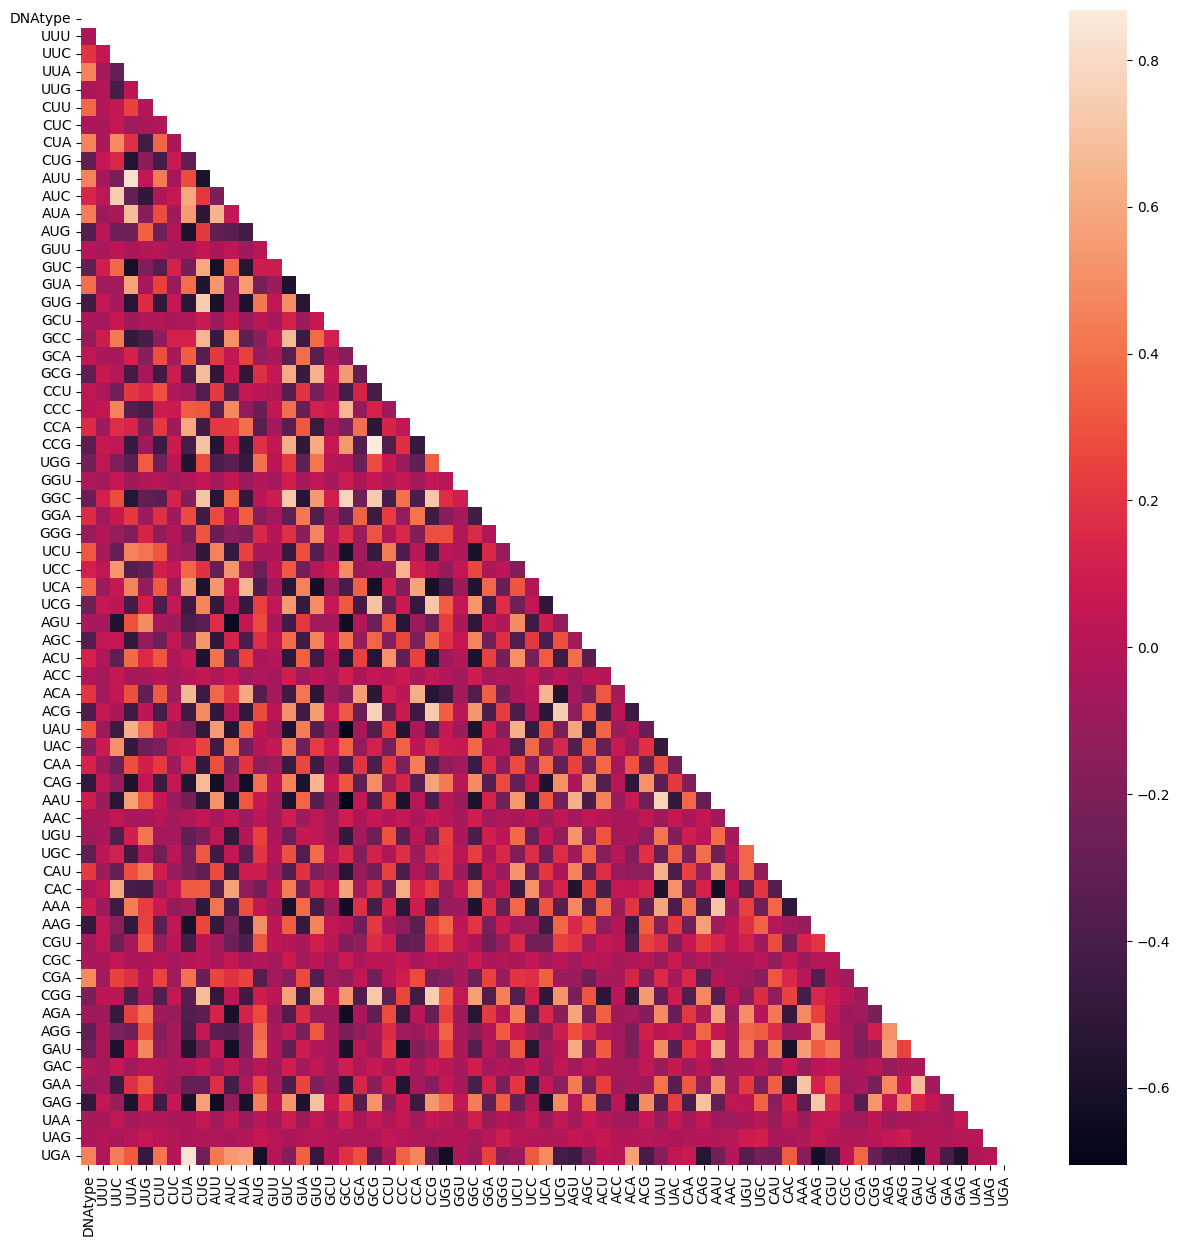

<Figure size 1500x1500 with 0 Axes>

<Axes: >

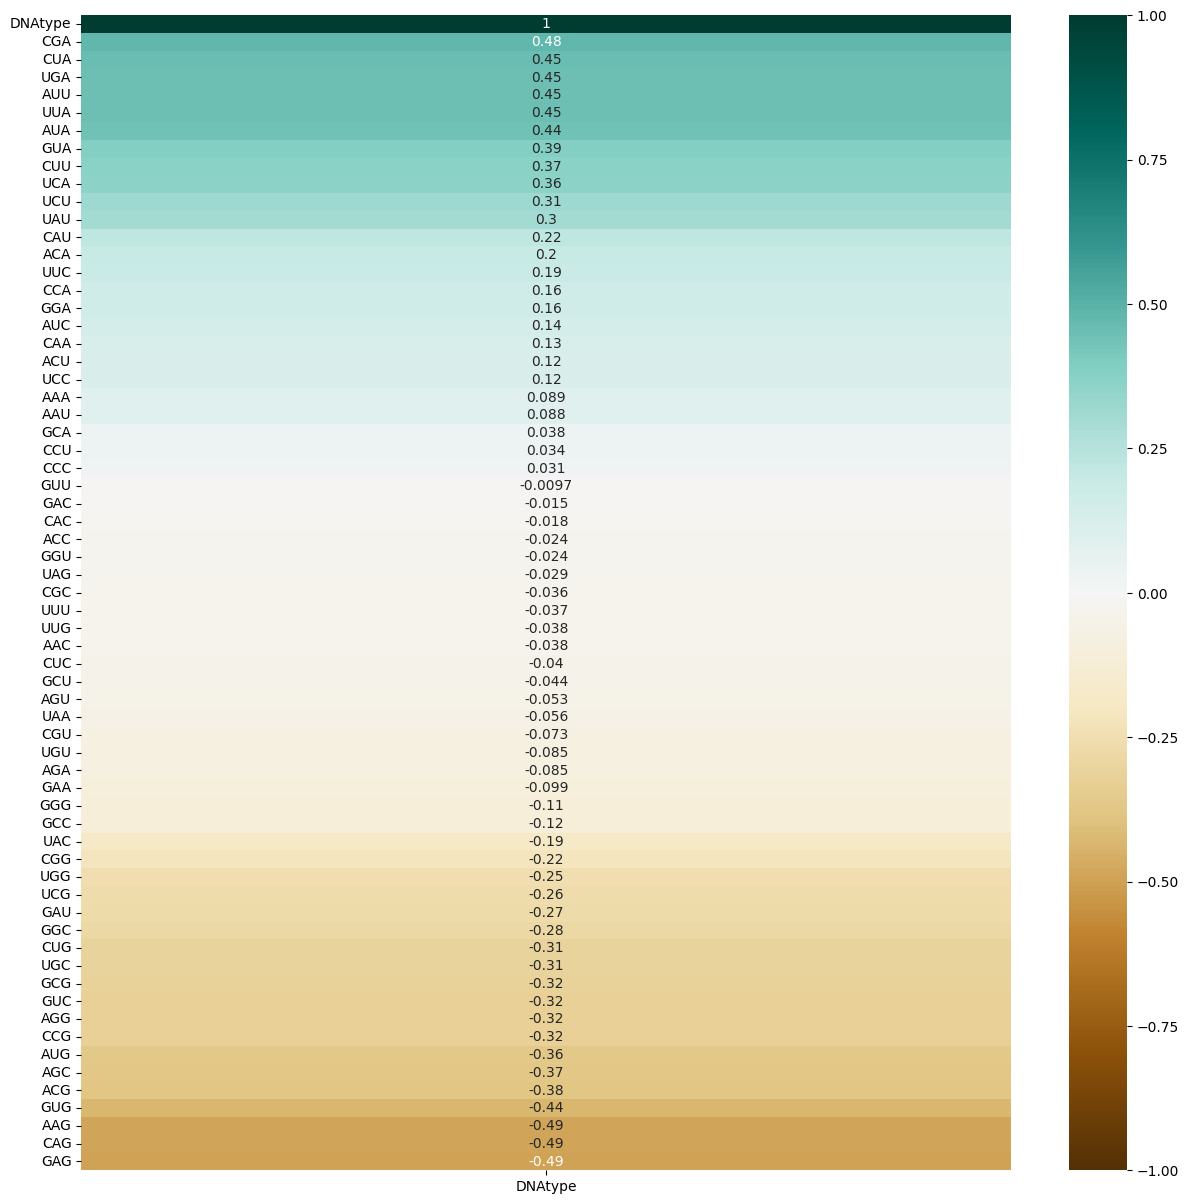

<Figure size 1500x1500 with 0 Axes>

<Axes: >

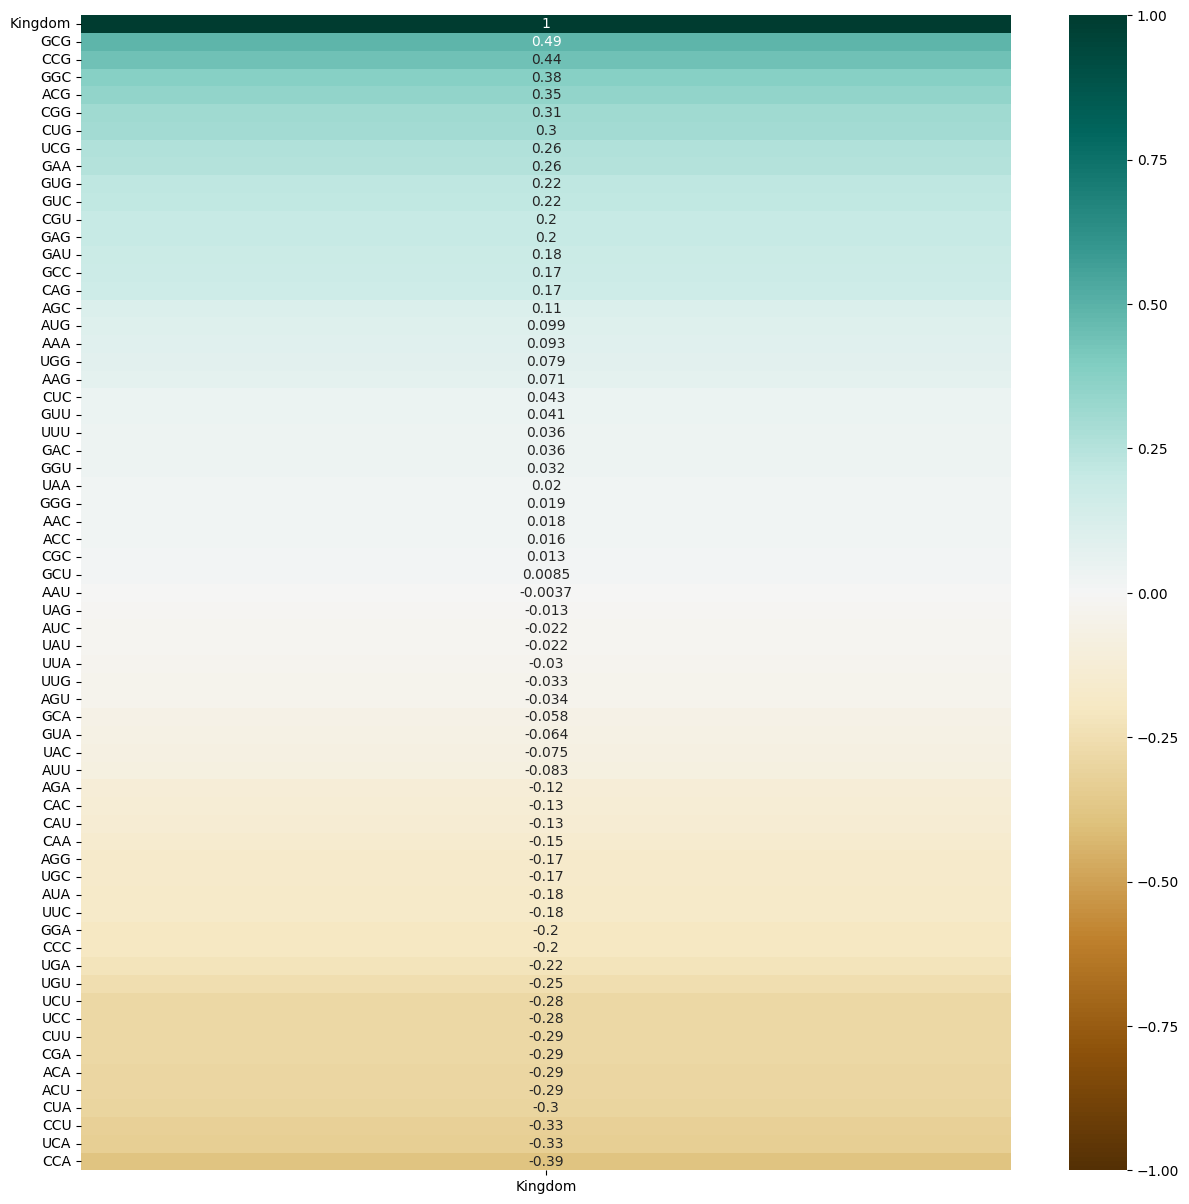

In [ ]:
corr = train.corr(numeric_only=True)
mask = np.triu(np.ones_like(corr, dtype=bool))
#display the heatmap
plt.figure(figsize=(15,15))
sns.heatmap(corr, mask=mask)
plt.show()
#display the correlation specifically for DNA type
plt.figure(figsize=(15,15))
sns.heatmap(train.corr(numeric_only=True)[['DNAtype']].sort_values(by='DNAtype', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.show()
#create a temporary integer representation of the Kingdom class using the binary one hot encoding for the purposes of displaying the correlation
yfig=[]
def binatodeci(binary):
    return sum(val*(2**idx) for idx, val in enumerate(reversed(binary)))
yfig=np.apply_along_axis(binatodeci, 1, y_train_kingdom_onehot)
xycombo=X_train.assign(Kingdom=yfig)
#display the correlation specifically for kingdom
plt.figure(figsize=(15,15))
sns.heatmap(xycombo.corr(numeric_only=True)[['Kingdom']].sort_values(by='Kingdom', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.show()

Here I plot the frequency of the DNA type classifications in the data. The train and test data seems to follow the same distribution, but there is a high bias towards one classification, which will likely have an impact on the classification models, and encourage them to favor prediction of the class that has the most samples.

array([[   0,    1,    2,    3,    4,    5,    6,    7,    9,   11,   12],
       [7407, 2320,  658,    2,   24,    1,    1,    1,    2,    1,    5]])

(array([9.727e+03, 6.580e+02, 2.000e+00, 2.400e+01, 1.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 6.000e+00]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <BarContainer object of 10 artists>)

array([[   0,    1,    2,    4,    5,   11],
       [1860,  579,  158,    7,    1,    1]])

(array([2.439e+03, 1.580e+02, 0.000e+00, 7.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0. ,  1.1,  2.2,  3.3,  4.4,  5.5,  6.6,  7.7,  8.8,  9.9, 11. ]),
 <BarContainer object of 10 artists>)

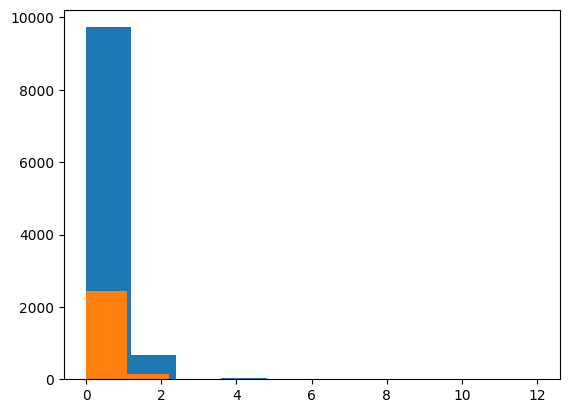

In [9]:
np.asarray(np.unique(train['DNAtype'], return_counts=True))
plt.hist(train['DNAtype'], label="Train")
np.asarray(np.unique(test['DNAtype'], return_counts=True))
plt.hist(test['DNAtype'], label="test")

To account for these severely skewed classes, I group DNA type classes 2 through 12 into one class.

<ipython-input-10-b3617b7c2ab1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_train_dnatype.loc[y_train_dnatype>1,]=2
<ipython-input-10-b3617b7c2ab1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_dnatype.loc[y_test_dnatype>1,]=2


array([[   0,    1,    2],
       [7407, 2320,  695]])

(array([7407.,    0.,    0.,    0.,    0., 2320.,    0.,    0.,    0.,
         695.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

array([[   0,    1,    2],
       [1860,  579,  167]])

(array([1860.,    0.,    0.,    0.,    0.,  579.,    0.,    0.,    0.,
         167.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

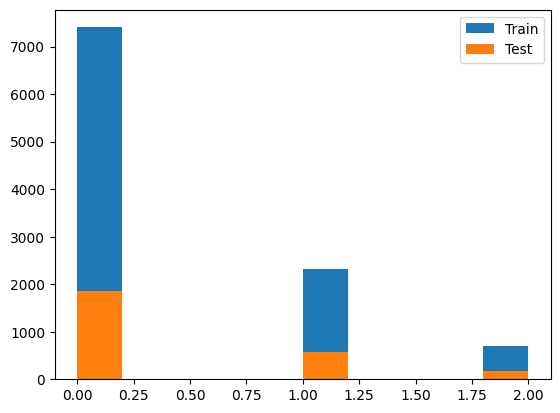

In [10]:
y_train_dnatype.loc[y_train_dnatype>1,]=2
y_test_dnatype.loc[y_test_dnatype>1,]=2
#also apply this change to the one hot encodings
y_train_dnatype_onehot = lbd.fit_transform(y_train_dnatype)
y_test_dnatype_onehot = lbd.fit_transform(y_test_dnatype)

np.asarray(np.unique(y_train_dnatype, return_counts=True))
plt.hist(y_train_dnatype, label="Train")
np.asarray(np.unique(y_test_dnatype, return_counts=True))
plt.hist(y_test_dnatype, label="Test")
plt.legend()

Here I plot the frequency of the Kingdom classifications in the data. The train and test data seems to again follow the same distribution, but the classifications are more likely across samples, although there is some bias towards certain classifications over others, it is not as severe as for DNA type.

array([['arc', 'bct', 'inv', 'mam', 'phg', 'plm', 'pln', 'pri', 'rod',
        'vrl', 'vrt'],
       [101, 2336, 1076, 458, 176, 14, 2018, 144, 172, 2265, 1662]],
      dtype=object)

(array([2265., 1076., 2336., 1662., 2018.,  101.,  172.,  458.,  176.,
         158.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

array([['arc', 'bct', 'inv', 'mam', 'phg', 'plm', 'pln', 'pri', 'rod',
        'vrl', 'vrt'],
       [25, 584, 269, 114, 44, 4, 505, 36, 43, 567, 415]], dtype=object)

(array([567., 269., 584., 415., 505.,  25.,  43., 114.,  44.,  40.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

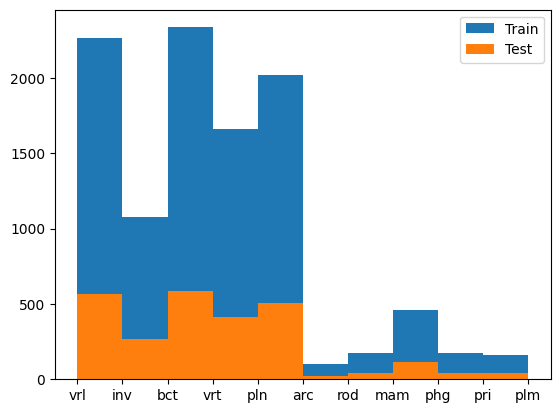

In [11]:
np.asarray(np.unique(train['Kingdom'], return_counts=True))
plt.hist(train['Kingdom'], label="Train")
np.asarray(np.unique(test['Kingdom'], return_counts=True))
plt.hist(test['Kingdom'], label="Test")
plt.legend()

### Dimensionality Reduction for Visualization
Here I used TSNE to reduce the dimensions of the data down to 3, and then visualized the data colored by Kingdom and DNA type.

In [13]:
tsne = TSNE(n_components=3, random_state=0, n_jobs=-1)
projections = tsne.fit_transform(X_train, )

fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=train['Kingdom'], labels={'color': 'Kingdom'}
)
fig.update_traces(marker_size=8)

In [14]:
fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=y_train_dnatype, labels={'color': 'DNAtype'}
)
fig.update_traces(marker_size=8)

## Clustering Analysis
Here, I use hierarchical clustering, Kmeans clustering, and DBSCAN to see how the data clusters. Although sillouhette score could be used to estimate the clusters, it is already known from the data that there are 11 kingdoms and 11 DNA types, so the number of clusters should be set to 11 to best represent that. It should be noted, generally, that due to the high number of dimensions present the results may not be ideal.

### Clustering Metrics
Here, I define the functions to evaluate the performance of the clustering algorithms, given that the true values of y are known.

In [12]:
def get_Ncounts(y_predict, y_true, X, k, j=None):
    #N is the total number of samples
    N = X.shape[0]
    #Nk is the total number of samples in cluster k
    Nk_mask = y_predict==k
    Nk = Nk_mask.sum()
    Nj, Nkj = None, None
    #if we have a label
    if j is not None:
        Nj_mask = y_true==j
        Nj = Nj_mask.sum()
        #samples that are both in cluster k and with label j
        Nkj = np.logical_and(Nk_mask, Nj_mask).sum()
    return N, Nk, Nj, Nkj

#computing precision
def precision(y_predict, y_true, X, k, j):
    N, Nk, Nj, Nkj = get_Ncounts(y_predict, y_true, X, k, j)
    return Nkj / (Nk + 1e-8)


#computing purity
def purity(y_predict, y_true, X, k):
    cls = np.unique(y_true)
    prec = [precision(y_predict, y_true, X, k, j) for j in cls]
    return max(prec)

def tot_purity(y_predict, y_true, X): #interpreted as a sort of accuracy in terms of clustering
    N = y_true.shape[0]
    nc = len(np.unique(y_true))
    p = 0
    for k in range(nc):
        N, Nk, _, _ = get_Ncounts(y_predict, y_true, X, k)
        pk = purity(y_predict, y_true, X, k)
        p += (Nk / N) * pk
    return p

### Hierarchical Clustering
First I define a function to plot the dendrograms resulting from hierarchical clustering.

In [13]:
def plot_dendrogram(Z=None, model=None, X=None, **kwargs):
    annotate_above = kwargs.pop('annotate_above', 0)

    # this block Reconstruct the linakge matrix if the standard model API was used
    if Z is None:
        if hasattr(model, 'distances_') and model.distances_ is not None:
            # create the counts of samples under each node
            counts = np.zeros(model.children_.shape[0])
            n_samples = len(model.labels_)
            for i, merge in enumerate(model.children_):
                current_count = 0
                for child_idx in merge:
                    if child_idx < n_samples:
                        current_count += 1  # leaf node
                    else:
                        current_count += counts[child_idx - n_samples]
                counts[i] = current_count

            Z = np.column_stack([model.children_, model.distances_,
                                              counts]).astype(float)
        else:
            Z = linkage(X, method=model.linkage, metric=model.metric)

    #This block checks if the n_clusters keyword argument is provided, if yes it calcualtes the threshold for coloring
    if 'n_clusters' in kwargs:
        n_clusters = kwargs.pop('n_clusters')
        # Set the cut point just above the last but 'n_clusters' merge
        kwargs['color_threshold'] = Z[-n_clusters, 2] + 1e-5 #select the height to cut, Z[-n_clusters, 2] retrieves the distance of the merge that results in exactly n_clusters clusters. This is because Z is sorted by merge order, so Z[-n_clusters] gives the n_clusters-th merge from the end (i.e., the merge that leaves exactly n_clusters clusters).
        #kwargs['color_threshold'] = None

    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    # Plot the corresponding dendrogram, with keyword arguments
    ddata = dendrogram(Z,ax=ax, **kwargs)

    # This block annotates nodes in the dendrogram
    for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']): #x, y coordinates and color
        x = 0.5 * sum(i[1:3]) #position where to plot on x
        y = d[1]  #position where to plot on x
        nid = np.where(Z[:,2] == y)[0][0] #This is the third column of the linkage matrix Z, which contains the distances between clusters at each merge.

        if y > annotate_above:
            plt.plot(x, y, 'o', c=c)
            plt.annotate(str(nid-Z.shape[0]), (x, y), xytext=(0, -5),# The text to be annotated. nid is the index of the merge, and Z.shape[0] is the number of merges. Subtracting these gives the node identifier.
                         textcoords='offset points',
                         va='top', ha='center')
    #This block draws a horizontal line at the color_threshold height to indicate the cut point for clusters.
    if kwargs['color_threshold']:
        plt.axhline(y=kwargs['color_threshold'], c='k')

    return fig, ax


Now I create a model to perform hierarchical clustering, using ward linkage and euclidean distance.

(<Figure size 2000x1000 with 1 Axes>, <Axes: >)

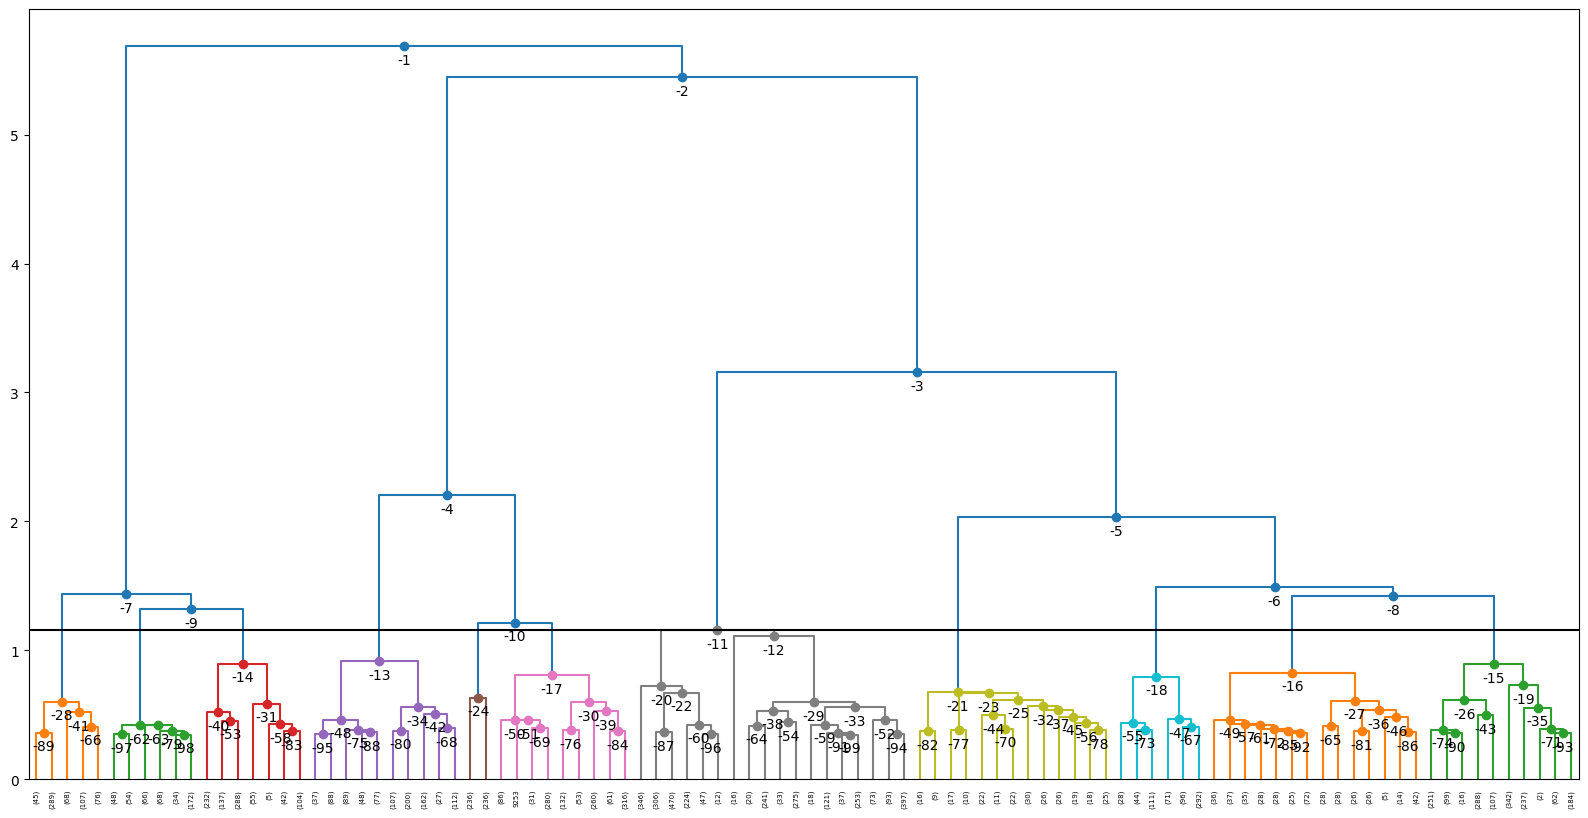

In [ ]:
n_clusters=11 #the number of clusters known from the data

model_k = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward') #create the model

y_predict_hierarchical_k = model_k.fit_predict(X_train) #predict the clusters

plot_dendrogram(model=model_k, X=X_train, truncate_mode='lastp', p=100,
                n_clusters=n_clusters,
                color_threshold=None)

I repeat the process with n_clusters=3, since that is the amount of clusters known for DNA type.

(<Figure size 2000x1000 with 1 Axes>, <Axes: >)

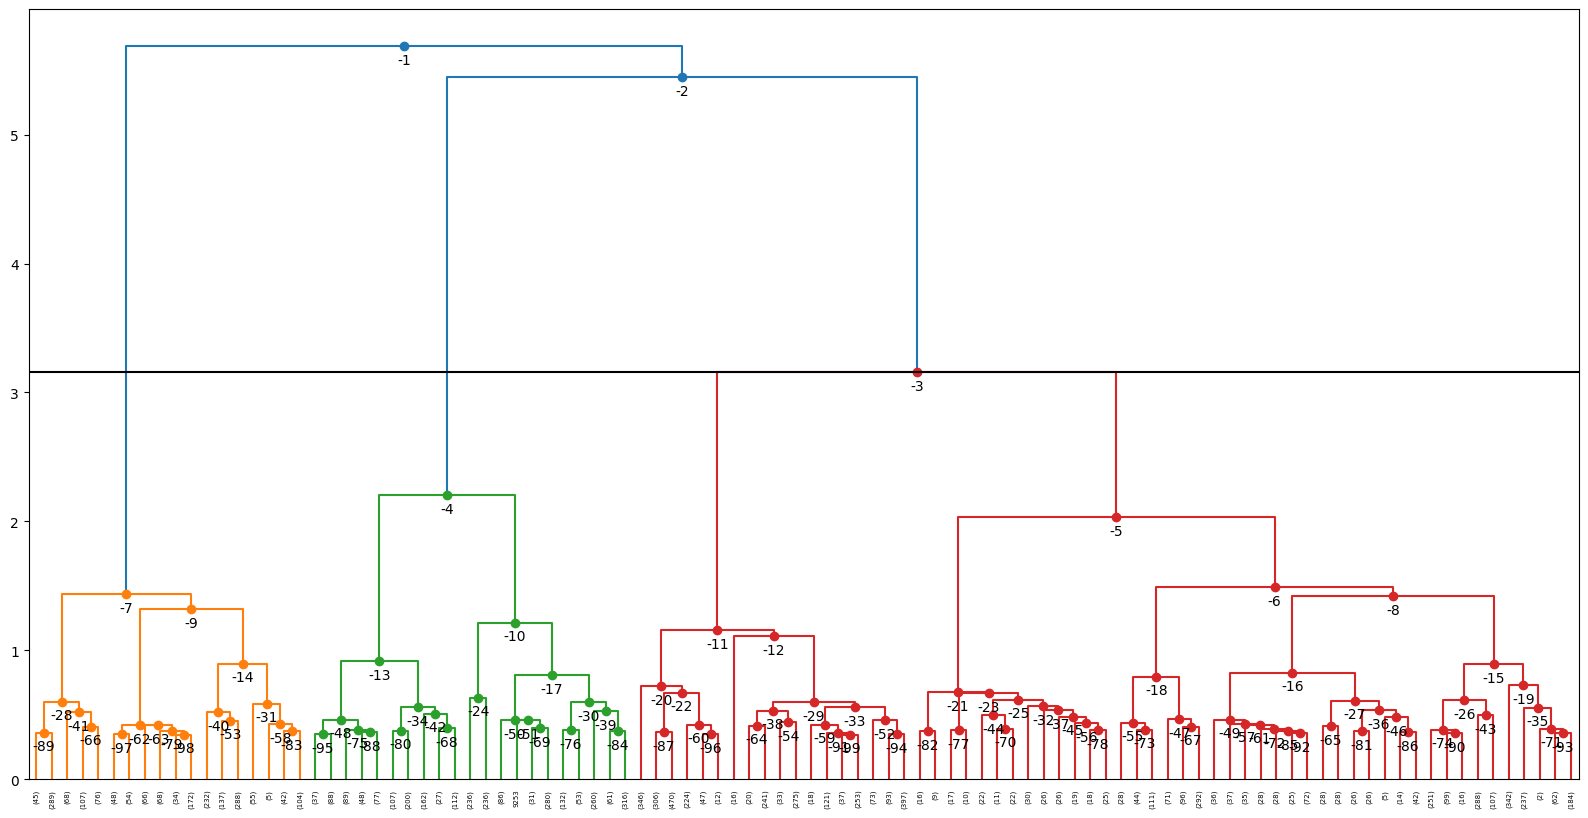

In [ ]:
n_clusters=3 #the number of clusters known from the data

model_d = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='ward') #create the model

y_predict_hierarchical_d = model_d.fit_predict(X_train) #predict the clusters

plot_dendrogram(model=model_d, X=X_train, truncate_mode='lastp', p=100,
                n_clusters=n_clusters,
                color_threshold=None)

I also plot the predicted clusters in a 3d space.

In [ ]:
fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=y_predict_hierarchical_k, labels={'color': 'Kingdom <br> Prediction'}
)
fig.update_traces(marker_size=8)

In [ ]:
fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=y_predict_hierarchical_d, labels={'color': 'DNA Type <br> Prediction'}
)
fig.update_traces(marker_size=8)

Using the tot_purity function, I evaluate these predictions compared to both kingdom and DNA type classifications.

In [ ]:
# the function inverse_tranform takes the one hot encoding and reverses it back to numbers, here ranging 0 to 10
print(tot_purity(y_predict_hierarchical_k, y_train_kingdom, X_train))
print(tot_purity(y_predict_hierarchical_d, y_train_dnatype, X_train))

0.5829015543969035
0.8918633659539363


The results indicate that the clustering is able to better model the DNA type rather than the kingdom.

### Kmeans


In [ ]:
model_k = KMeans(n_clusters=11, init='random', random_state=0) #create the model
y_predict_km_k = model_k.fit_predict(X_train) #predict the clusters

fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=y_predict_km_k, labels={'color': 'Kingdom <br>Prediction'}
)
fig.update_traces(marker_size=8)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [ ]:
model_d = KMeans(n_clusters=3, init='random', random_state=0) #create the model
y_predict_km_d = model_d.fit_predict(X_train) #predict the clusters

fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=y_predict_km_d, labels={'color': 'DNA Type <br>Prediction'}
)
fig.update_traces(marker_size=8)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



I once again use the tot_purity function previously defined to evaluate the performance, this time for Kmeans.

In [ ]:
# the function inverse_tranform takes the one hot encoding and reverses it back to numbers, here ranging 0 to 10
print(tot_purity(y_predict_km_k, y_train_kingdom, X_train))
print(tot_purity(y_predict_km_d, y_train_dnatype, X_train))

0.5685089234243642
0.8926309729391836


Here, the results are similar to hierarchical clustering, in that the 3 cluster clustering for DNA type returns a better score.

### DBSCAN
Despite knowing the number of clusters I should have, you do not specify the number of clusters for DBSCAN, so I first use cross validation to determine the best values for its other parameters, eps and min_samples.

In [15]:
#define a make scorer function because DBSCAN uses fit_predict, rather than
def make_scorer(metric):
    def scorer(estimator, X, y):
        y_pred = estimator.fit_predict(X)
        return metric(y_pred, y, X)
    return scorer

In [19]:
#define the model
model = DBSCAN(eps=.1, min_samples=128)
#define the range of parameters
params = {'eps': [x / 10.0 for x in range(1,3)], 'min_samples': range(118,138)}
#cross validation for kingdom classification
cvk = GridSearchCV(model, params, scoring=make_scorer(tot_purity), cv=5, n_jobs=-1)
cvk = cvk.fit(X_train, y_train_kingdom)
#cross validation for DNA type classification
cvd = GridSearchCV(model, params, scoring=make_scorer(tot_purity), cv=5, n_jobs=-1)
cvd = cvd.fit(X_train, y_train_dnatype)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



In [20]:
#the results regarding kingdom classification
print(cvk.best_params_)
pd.DataFrame(cvk.cv_results_)

{'eps': 0.2, 'min_samples': 118}


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_eps  \
0        2.139612      0.034851         0.268104        0.034524       0.1   
1        2.119150      0.030883         0.262936        0.032573       0.1   
2        2.136608      0.015604         0.243151        0.010172       0.1   
3        1.910890      0.144313         0.245933        0.002264       0.1   
4        1.871564      0.034520         0.250625        0.012858       0.1   
5        1.883234      0.067123         0.264985        0.005142       0.1   
6        1.890013      0.038717         0.248865        0.012803       0.1   
7        1.821918      0.045561         0.247276        0.007102       0.1   
8        1.881120      0.085970         0.242345        0.009765       0.1   
9        1.788737      0.038939         0.289087        0.054905       0.1   
10       1.806678      0.045038         0.243942        0.012728       0.1   
11       1.865326      0.151010         0.250822        0.017300       0.1   
12       1.882338      0.040550         0.253075        0.019270       0.1   
13       1.841769      0.081782         0.247427        0.024193       0.1   
14       1.867646      0.107309         0.267483        0.028881       0.1   
15       1.800095      0.039842         0.290170        0.053677       0.1   
16       1.833812      0.139226         0.240971        0.014763       0.1   
17       1.777236      0.079394         0.242320        0.014713       0.1   
18       1.953836      0.049813         0.287529        0.037015       0.1   
19       1.783712      0.075247         0.250241        0.007844       0.1   
20       3.487592      0.101930         0.355393        0.055657       0.2   
21       3.704456      0.109712         0.383500        0.059728       0.2   
22       3.524598      0.139296         0.356486        0.034663       0.2   
23       3.370937      0.220475         0.350862        0.077383       0.2   
24       3.807806      0.318029         0.340896        0.049210       0.2   
25       3.713361      0.225411         0.336980        0.071713       0.2   
26       3.567251      0.275333         0.367743        0.051118       0.2   
27       3.815817      0.203540         0.329228        0.025297       0.2   
28       3.513082      0.411296         0.369347        0.053988       0.2   
29       3.504632      0.262505         0.384201        0.068739       0.2   
30       3.422426      0.094153         0.369258        0.058325       0.2   
31       3.386674      0.260933         0.379123        0.057401       0.2   
32       3.741368      0.498613         0.380883        0.071159       0.2   
33       3.545810      0.397906         0.333872        0.037546       0.2   
34       3.517823      0.157908         0.353462        0.041230       0.2   
35       3.521621      0.491070         0.362644        0.048583       0.2   
36       3.515139      0.262989         0.361713        0.026007       0.2   
37       3.559501      0.384534         0.361731        0.101801       0.2   
38       3.304751      0.344929         0.250128        0.047987       0.2   
39       2.728172      0.171950         0.202213        0.017833       0.2   

   param_min_samples                            params  split0_test_score  \
0                118  {'eps': 0.1, 'min_samples': 118}           0.229257   
1                119  {'eps': 0.1, 'min_samples': 119}           0.229257   
2                120  {'eps': 0.1, 'min_samples': 120}           0.229257   
3                121  {'eps': 0.1, 'min_samples': 121}           0.229257   
4                122  {'eps': 0.1, 'min_samples': 122}           0.229257   
5                123  {'eps': 0.1, 'min_samples': 123}           0.229257   
6                124  {'eps': 0.1, 'min_samples': 124}           0.229257   
7                125  {'eps': 0.1, 'min_samples': 125}           0.229257   
8                126  {'eps': 0.1, 'min_samples': 126}           0.229257   
9                127  {'eps': 0.1, 

In [21]:
#the results regarding DNA type classification
print(cvd.best_params_)
pd.DataFrame(cvd.cv_results_)

{'eps': 0.2, 'min_samples': 118}


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_eps  \
0        1.681976      0.119753         0.132849        0.018391       0.1   
1        1.535802      0.068461         0.115942        0.012206       0.1   
2        1.966407      0.374018         0.139438        0.046746       0.1   
3        1.755390      0.249392         0.119578        0.005764       0.1   
4        1.707524      0.200312         0.119490        0.001798       0.1   
5        1.883933      0.247901         0.125389        0.007683       0.1   
6        1.688319      0.107636         0.116216        0.002670       0.1   
7        1.770138      0.129073         0.118613        0.004251       0.1   
8        1.892225      0.062160         0.152845        0.040149       0.1   
9        1.582706      0.041156         0.127336        0.020215       0.1   
10       1.734509      0.134192         0.116591        0.007376       0.1   
11       1.933995      0.213531         0.144951        0.041266       0.1   
12       1.636741      0.082179         0.127241        0.016728       0.1   
13       1.749072      0.126151         0.130625        0.020393       0.1   
14       1.866261      0.052139         0.144427        0.038257       0.1   
15       1.633717      0.105737         0.121115        0.014402       0.1   
16       1.769414      0.191376         0.135145        0.025447       0.1   
17       1.774002      0.164763         0.119930        0.006343       0.1   
18       1.808479      0.171282         0.147024        0.033311       0.1   
19       1.699396      0.124179         0.121814        0.005535       0.1   
20       3.422826      0.280047         0.229342        0.041660       0.2   
21       3.524965      0.195781         0.290036        0.060850       0.2   
22       3.518328      0.133318         0.225542        0.036177       0.2   
23       3.212456      0.320498         0.233689        0.059361       0.2   
24       3.301896      0.370117         0.184581        0.019425       0.2   
25       3.553625      0.364451         0.206128        0.033549       0.2   
26       3.383275      0.501158         0.234345        0.034879       0.2   
27       3.203583      0.207697         0.234804        0.053612       0.2   
28       3.436427      0.494208         0.205246        0.014014       0.2   
29       3.339096      0.367236         0.217082        0.019656       0.2   
30       3.477888      0.376234         0.238357        0.074574       0.2   
31       3.093127      0.115939         0.206828        0.012592       0.2   
32       3.405366      0.376329         0.245211        0.034710       0.2   
33       3.545450      0.247236         0.212489        0.038132       0.2   
34       3.682891      0.531339         0.209653        0.008843       0.2   
35       3.360467      0.236024         0.224692        0.053082       0.2   
36       3.338364      0.243918         0.198126        0.018900       0.2   
37       3.219193      0.148400         0.172896        0.019861       0.2   
38       3.229774      0.363336         0.131245        0.019299       0.2   
39       2.634900      0.138561         0.114667        0.008475       0.2   

   param_min_samples                            params  split0_test_score  \
0                118  {'eps': 0.1, 'min_samples': 118}           0.705036   
1                119  {'eps': 0.1, 'min_samples': 119}           0.704556   
2                120  {'eps': 0.1, 'min_samples': 120}           0.704556   
3                121  {'eps': 0.1, 'min_samples': 121}           0.704556   
4                122  {'eps': 0.1, 'min_samples': 122}           0.704556   
5                123  {'eps': 0.1, 'min_samples': 123}           0.704556   
6                124  {'eps': 0.1, 'min_samples': 124}           0.704556   
7                125  {'eps': 0.1, 'min_samples': 125}           0.704556   
8                126  {'eps': 0.1, 'min_samples': 126}           0.704556   
9                127  {'eps': 0.1, 

The cross validation chooses eps=0.2 and min_samples=118 as those producing the best model, so I use these to build the model.

In [22]:
#create the model
model = DBSCAN(eps=0.2, min_samples=118)
y_predict_db = model.fit_predict(X_train) #fit and predict the clusters

#visualize
fig = px.scatter_3d(
    projections, x=0, y=1, z=2,
    color=y_predict_db, labels={'color': 'Prediction'}
)
fig.update_traces(marker_size=8)

The visualization shows that DBSCAN performs rather poorly. I can asses this evaluation using the tot_purity function.

In [23]:
print(tot_purity(y_predict_db, y_train_kingdom, X_train))
print(tot_purity(y_predict_db, y_train_dnatype, X_train))

0.224141239685066
0.7105162156968808


Given the purity scores from all three models, it can be said that hierarchical clustering produces the best results given this data. However, it cannot be said that the data clusters into classes that are easily identifiable.

# Classification
Using the codon frequencies, I use several different classification model types to attempt to predict both kingdom and DNA type classifications.

First, I define an accuracy function, which will be used as a scoring metric for the classifiers.

In [15]:
#accuracy= n_correct/n_total
def accuracy(y_pred, y_true):
    return (y_pred==y_true).sum()/len(y_true)

Because the test data lacks AGA codon frequency, for now we will use the training data without it as well.

In [36]:
X_train_noaga = X_train.drop(columns='AGA')
X_train_noaga

UUU      UUC      UUA      UUG      CUU      CUC      CUA      CUG  \
0      0.01541  0.00927  0.01720  0.01825  0.01436  0.02303  0.01555  0.02094   
1      0.01213  0.02515  0.00268  0.01352  0.01372  0.01143  0.00775  0.02992   
2      0.02580  0.01618  0.03606  0.01354  0.00848  0.02067  0.01041  0.00278   
3      0.00128  0.02141  0.01225  0.01649  0.01330  0.01308  0.00399  0.02834   
4      0.03169  0.01780  0.03893  0.00000  0.06240  0.01056  0.05262  0.01408   
...        ...      ...      ...      ...      ...      ...      ...      ...   
10417  0.02289  0.02959  0.00614  0.02680  0.01452  0.02178  0.00558  0.01228   
10418  0.02532  0.01557  0.00878  0.01185  0.01160  0.02654  0.00979  0.02313   
10419  0.01614  0.02618  0.00131  0.01003  0.02661  0.01658  0.00218  0.04712   
10420  0.00196  0.01761  0.04501  0.03131  0.02544  0.00978  0.01761  0.00783   
10421  0.01754  0.03704  0.01559  0.01852  0.01949  0.05263  0.02534  0.00975   

           AUU      AUC  ...      CGA      CGG      AGG      GAU      GAC  \
0      0.01885  0.01226  ...  0.00853  0.00643  0.01182  0.02812  0.00838   
1      0.01352  0.03370  ...  0.00378  0.00268  0.01412  0.03280  0.02555   
2      0.03250  0.01768  ...  0.00570  0.00114  0.00499  0.03756  0.02523   
3      0.02508  0.02611  ...  0.00359  0.01177  0.00422  0.03316  0.02229   
4      0.03873  0.03873  ...  0.01056  0.00000  0.00000  0.00020  0.01389   
...        ...      ...  ...      ...      ...      ...      ...      ...   
10417  0.02401  0.01954  ...  0.00279  0.00558  0.01173  0.03071  0.01954   
10418  0.01773  0.01977  ...  0.00791  0.00477  0.01008  0.02070  0.00726   
10419  0.01920  0.03054  ...  0.00262  0.01702  0.00567  0.02487  0.00000   
10420  0.04305  0.00587  ...  0.01761  0.00391  0.00391  0.02348  0.01957   
10421  0.04483  0.01559  ...  0.03314  0.00390  0.00975  0.03314  0.00390   

           GAA      GAG      UAA      UAG      UGA  
0      0.03365  0.01974  0.01511  0.00030  0.00030  
1      0.03708  0.05398  0.03330  0.00030  0.00050  
2      0.05388  0.01946  0.02245  0.00121  0.00086  
3      0.03444  0.02370  0.00831  0.00028  0.00063  
4      0.02465  0.00352  0.00352  0.00000  0.02465  
...        ...      ...      ...      ...      ...  
10417  0.01787  0.02848  0.03127  0.00112  0.00000  
10418  0.02388  0.02233  0.01814  0.00025  0.00038  
10419  0.02661  0.02618  0.01353  0.00000  0.00349  
10420  0.03523  0.00978  0.00196  0.00000  0.00196  
10421  0.03899  0.00780  0.00195  0.00000  0.00195  

[10422 rows x 63 columns]

## Features Selection

## Logistic Regression

### Parameters Selection
First, I use GridSearchCV to find the optimal penalty and value of C for each type of classification. As I saw in the data visualization, the classes are highly skewed, so to account for this I set class_weight to balanced.

In [37]:
#normalize the data
scaler=StandardScaler()
X_train_std = scaler.fit_transform(X_train_noaga)

#define the model
#because the classes are highly skewed, I set the class weight to balanced so the model considers the classes with less samples
model = LogisticRegression(solver='saga', penalty='l2', C=0.1, max_iter=8000, multi_class='multinomial', class_weight='balanced')

#define the range of parameters
#because some of the features are highly correlated, the model has difficulty converging at certain values of C
params = {'solver':['saga'],'penalty':['l1','l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'max_iter':[8000], 'multi_class':['multinomial'], 'class_weight':['balanced']}
#cross validation for kingdom classification
cvk = GridSearchCV(model, params, scoring=sklearn.metrics.make_scorer(accuracy), cv=3, n_jobs=-1) #specify which make_scorer, because I previously overwrote it as a function
cvk = cvk.fit(X_train_std, y_train_kingdom)
#cross validation for DNA type classification
#this cross validation will throw out several warning because the classes are extremely skewed
cvd = GridSearchCV(model, params, scoring=sklearn.metrics.make_scorer(accuracy), cv=3, n_jobs=-1)
cvd = cvd.fit(X_train_std, y_train_dnatype)

In [38]:
#the results regarding kingdom classification
print(cvk.best_params_)
pd.DataFrame(cvk.cv_results_)

{'C': 1000, 'class_weight': 'balanced', 'max_iter': 8000, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'saga'}


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0        1.316952      0.166747         0.003024        0.000065   0.001   
1        2.360815      0.632496         0.002980        0.000029   0.001   
2        9.388709      2.189165         0.003055        0.000041    0.01   
3       10.456775      3.473912         0.002992        0.000021    0.01   
4       50.119204     17.842182         0.003373        0.000210     0.1   
5       23.611745      7.987769         0.003167        0.000254     0.1   
6      223.127502     46.520573         0.003121        0.000180       1   
7       71.850843     19.689465         0.003069        0.000181       1   
8      336.672740     21.453998         0.002640        0.000360      10   
9      167.222155     26.633228         0.003317        0.000027      10   
10     348.086174     20.377880         0.002190        0.000103     100   
11     213.202558     19.550261         0.003348        0.000045     100   
12     305.530978     32.038421         0.002335        0.000091    1000   
13     176.141768     20.857994         0.002165        0.000146    1000   

   param_class_weight param_max_iter param_multi_class param_penalty  \
0            balanced           8000       multinomial            l1   
1            balanced           8000       multinomial            l2   
2            balanced           8000       multinomial            l1   
3            balanced           8000       multinomial            l2   
4            balanced           8000       multinomial            l1   
5            balanced           8000       multinomial            l2   
6            balanced           8000       multinomial            l1   
7            balanced           8000       multinomial            l2   
8            balanced           8000       multinomial            l1   
9            balanced           8000       multinomial            l2   
10           balanced           8000       multinomial            l1   
11           balanced           8000       multinomial            l2   
12           balanced           8000       multinomial            l1   
13           balanced           8000       multinomial            l2   

   param_solver                                             params  \
0          saga  {'C': 0.001, 'class_weight': 'balanced', 'max_...   
1          saga  {'C': 0.001, 'class_weight': 'balanced', 'max_...   
2          saga  {'C': 0.01, 'class_weight': 'balanced', 'max_i...   
3          saga  {'C': 0.01, 'class_weight': 'balanced', 'max_i...   
4          saga  {'C': 0.1, 'class_weight': 'balanced', 'max_it...   
5          saga  {'C': 0.1, 'class_weight': 'balanced', 'max_it...   
6          saga  {'C': 1, 'class_weight': 'balanced', 'max_iter...   
7          saga  {'C': 1, 'class_weight': 'balanced', 'max_iter...   
8          saga  {'C': 10, 'class_weight': 'balanced', 'max_ite...   
9          saga  {'C': 10, 'class_weight': 'balanced', 'max_ite...   
10         saga  {'C': 100, 'class_weight': 'balanced', 'max_it...   
11         saga  {'C': 100, 'class_weight': 'balanced', 'max_it...   
12         saga  {'C': 1000, 'class_weight': 'balanced', 'max_i...   
13         saga  {'C': 1000, 'class_weight': 'balanced', 'max_i...   

    split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0            0.015544           0.023028           0.033679         0.024084   
1            0.616868           0.636442           0.637306         0.630205   
2            0.589234           0.601612           0.601612         0.597486   
3            0.735463           0.744675           0.751295         0.743811   
4            0.766839           0.766552           0.780368         0.771253   
5            0.780944           0.776051           0.780656         0.779217   
6            0.790155           0.786413           0.789580         0.788716   
7            0.788428           0.784974           0.789868         0.787757   
8          

In [39]:
#the results regarding DNA type classification
print(cvd.best_params_)
pd.DataFrame(cvd.cv_results_)

{'C': 0.1, 'class_weight': 'balanced', 'max_iter': 8000, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga'}


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0        0.476951      0.080063         0.001822        0.000073   0.001   
1        0.669766      0.181585         0.001770        0.000047   0.001   
2        2.570344      0.675229         0.001819        0.000079    0.01   
3        5.668948      5.022213         0.001876        0.000081    0.01   
4       75.107624     78.124016         0.001990        0.000386     0.1   
5       51.570611     61.390312         0.002006        0.000099     0.1   
6      108.389582     53.807847         0.002130        0.000158       1   
7       66.086075     56.917949         0.001843        0.000156       1   
8      114.701508     61.876677         0.002159        0.000172      10   
9       76.479845     44.743582         0.001794        0.000263      10   
10     118.155650     49.163977         0.001995        0.000246     100   
11      73.929942     34.904220         0.002107        0.000209     100   
12     104.258014     44.094030         0.001702        0.000061    1000   
13      67.782203     28.766565         0.001747        0.000381    1000   

   param_class_weight param_max_iter param_multi_class param_penalty  \
0            balanced           8000       multinomial            l1   
1            balanced           8000       multinomial            l2   
2            balanced           8000       multinomial            l1   
3            balanced           8000       multinomial            l2   
4            balanced           8000       multinomial            l1   
5            balanced           8000       multinomial            l2   
6            balanced           8000       multinomial            l1   
7            balanced           8000       multinomial            l2   
8            balanced           8000       multinomial            l1   
9            balanced           8000       multinomial            l2   
10           balanced           8000       multinomial            l1   
11           balanced           8000       multinomial            l2   
12           balanced           8000       multinomial            l1   
13           balanced           8000       multinomial            l2   

   param_solver                                             params  \
0          saga  {'C': 0.001, 'class_weight': 'balanced', 'max_...   
1          saga  {'C': 0.001, 'class_weight': 'balanced', 'max_...   
2          saga  {'C': 0.01, 'class_weight': 'balanced', 'max_i...   
3          saga  {'C': 0.01, 'class_weight': 'balanced', 'max_i...   
4          saga  {'C': 0.1, 'class_weight': 'balanced', 'max_it...   
5          saga  {'C': 0.1, 'class_weight': 'balanced', 'max_it...   
6          saga  {'C': 1, 'class_weight': 'balanced', 'max_iter...   
7          saga  {'C': 1, 'class_weight': 'balanced', 'max_iter...   
8          saga  {'C': 10, 'class_weight': 'balanced', 'max_ite...   
9          saga  {'C': 10, 'class_weight': 'balanced', 'max_ite...   
10         saga  {'C': 100, 'class_weight': 'balanced', 'max_it...   
11         saga  {'C': 100, 'class_weight': 'balanced', 'max_it...   
12         saga  {'C': 1000, 'class_weight': 'balanced', 'max_i...   
13         saga  {'C': 1000, 'class_weight': 'balanced', 'max_i...   

    split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0            0.945596           0.940415           0.934657         0.940223   
1            0.964882           0.970639           0.964594         0.966705   
2            0.963155           0.970639           0.959413         0.964402   
3            0.976396           0.978987           0.972078         0.975820   
4            0.977260           0.978123           0.973230         0.976204   
5            0.977260           0.976972           0.974093         0.976108   
6            0.976396           0.975820           0.975245         0.975820   
7            0.976684           0.975533           0.975245         0.975820   
8          

The features selection gives as best parameters C=1000 and l2 penalty for kingdom classification, and C=0.1 and l1 penalty for DNA type classification.

### Training Score
Now I can use cross validation again, this time to assess the accuracy of the model on the training data using these parameters.

In [40]:
#create the model
model = LogisticRegression(solver='saga', penalty='l2', C=1000, max_iter=5000, multi_class='multinomial', class_weight='balanced')
#cross validation
scores = cross_val_score(model, X_train_noaga, y_train_kingdom, cv=3, scoring=sklearn.metrics.make_scorer(accuracy), n_jobs=-1)
#take the mean of the scores for each iteration
kingdom_val_score=np.mean(scores)
#repeat for DNA type
model = LogisticRegression(solver='saga', penalty='l1', C=0.1, max_iter=5000, multi_class='multinomial', class_weight='balanced')
scores = cross_val_score(model, X_train_noaga, y_train_dnatype, cv=3, scoring=sklearn.metrics.make_scorer(accuracy), n_jobs=-1)
dna_val_score=np.mean(scores)

In [41]:
print("Validation score for Kingdom classification: ", kingdom_val_score)
print("Validation score for DNA type classification: ", dna_val_score)

Validation score for Kingdom classification:  0.7035118019573979
Validation score for DNA type classification:  0.8007100364613318


These scores, show relatively average performance of the logistic regression classifier on the data.

## Quadratic Discriminant Analysis

Due to the size of the data, it is better to use quadratic discriminant analysis rather than linear discriminant analysis.

### Training Score
There are no parameters to fine-tune, so I go straight to cross validation to assess accuracy.

In [42]:
#create the model
model = QDA(store_covariance=True)

#cross validation
scores = cross_val_score(model, X_train_noaga, y_train_kingdom, cv=5, scoring=sklearn.metrics.make_scorer(accuracy))
#take the mean of the scores for each iteration
kingdom_val_score=np.mean(scores)
#repeat for DNA type
#because the classes are highly skewed, this throws several warnings
scores = cross_val_score(model, X_train_noaga, y_train_dnatype, cv=5, scoring=sklearn.metrics.make_scorer(accuracy))
dna_val_score=np.mean(scores)

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning:

Variables are collinear

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning:

Variables are collinear

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning:

Variables are collinear

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning:

Variables are collinear

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning:

Variables are collinear



In [43]:
print("Validation score for Kingdom classification: ", kingdom_val_score)
print("Validation score for DNA type classification: ", dna_val_score)

Validation score for Kingdom classification:  0.8208588906226266
Validation score for DNA type classification:  0.984455644697294


These validation scores indicate that the LDA model (with polynomial features) is able to classify the data remarkably well. However, the warning given by the model stating that the variables are collinear may indicate that the results are not accurate.

## K-Nearest Neighbors

### Parameters Selection
First, I perform cross validation to determine the best number of K neighbors to consider in the model.

In [44]:
#define the model
model = KNeighborsClassifier()

#define the range of parameters
params = {'n_neighbors': range(1, 15)}

#cross validation for kingdom classification
cvk = GridSearchCV(model, params, scoring=sklearn.metrics.make_scorer(accuracy), cv=10, n_jobs=-1) #specify which make_scorer, because I previously overwrote it as a function
cvk = cvk.fit(X_train_noaga, y_train_kingdom)
#cross validation for DNA type classification
cvd = GridSearchCV(model, params, scoring=sklearn.metrics.make_scorer(accuracy), cv=10, n_jobs=-1)
cvd = cvd.fit(X_train_noaga, y_train_dnatype)

In [45]:
#the results regarding kingdom classification
print(cvk.best_params_)
pd.DataFrame(cvk.cv_results_)

{'n_neighbors': 3}


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.030459      0.001369         0.219012        0.007816   
1        0.030625      0.003980         0.214149        0.016997   
2        0.027316      0.001839         0.192747        0.007536   
3        0.031517      0.005329         0.203119        0.008212   
4        0.030771      0.003851         0.199160        0.001881   
5        0.031033      0.002532         0.203097        0.007534   
6        0.030911      0.002928         0.198700        0.002307   
7        0.030935      0.002817         0.203410        0.007655   
8        0.031944      0.002134         0.203296        0.003898   
9        0.031029      0.002856         0.205369        0.010025   
10       0.030149      0.002412         0.204546        0.005828   
11       0.031973      0.002744         0.204714        0.005340   
12       0.031006      0.003207         0.206827        0.006436   
13       0.031539      0.002890         0.172446        0.013873   

   param_n_neighbors               params  split0_test_score  \
0                  1   {'n_neighbors': 1}           0.836050   
1                  2   {'n_neighbors': 2}           0.817833   
2                  3   {'n_neighbors': 3}           0.846596   
3                  4   {'n_neighbors': 4}           0.841802   
4                  5   {'n_neighbors': 5}           0.848514   
5                  6   {'n_neighbors': 6}           0.844679   
6                  7   {'n_neighbors': 7}           0.850431   
7                  8   {'n_neighbors': 8}           0.839885   
8                  9   {'n_neighbors': 9}           0.853308   
9                 10  {'n_neighbors': 10}           0.846596   
10                11  {'n_neighbors': 11}           0.842761   
11                12  {'n_neighbors': 12}           0.841802   
12                13  {'n_neighbors': 13}           0.839885   
13                14  {'n_neighbors': 14}           0.837009   

    split1_test_score  split2_test_score  split3_test_score  \
0            0.842761           0.828215           0.821497   
1            0.804410           0.791747           0.809021   
2            0.843720           0.823417           0.833013   
3            0.838926           0.816699           0.826296   
4            0.850431           0.829175           0.830134   
5            0.847555           0.826296           0.826296   
6            0.850431           0.821497           0.825336   
7            0.853308           0.822457           0.821497   
8            0.858102           0.828215           0.821497   
9            0.843720           0.822457           0.825336   
10           0.850431           0.824376           0.825336   
11           0.840844           0.818618           0.819578   
12           0.841802           0.817658           0.830134   
13           0.836050           0.811900           0.812860   

    split4_test_score  split5_test_score  split6_test_score  \
0            0.847409           0.828215           0.842610   
1            0.828215           0.814779           0.823417   
2            0.863724           0.834933           0.856046   
3            0.857006           0.824376           0.850288   
4            0.860845           0.833013           0.839731   
5            0.855086           0.823417           0.835893   
6            0.859885           0.823417           0.842610   
7            0.858925           0.824376           0.833013   
8            0.855086           0.822457           0.835893   
9            0.855086           0.820537           0.832054   
10           0.846449           0.826296           0.830134   
11           0.849328           0.822457           0.833013   
12           0.845489           0.821497           0.833013   
13           0.841651           0.815739           0.831094   

    split7_test_score  split8_test_score  split9_test_score  mean_test_score  \
0            0.827255           0.837812          

In [46]:
#the results regarding DNA type classification
print(cvd.best_params_)
pd.DataFrame(cvd.cv_results_)

{'n_neighbors': 2}


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.013165      0.001433         0.194414        0.005727   
1        0.013307      0.002101         0.201205        0.004216   
2        0.014060      0.001157         0.204711        0.016035   
3        0.013477      0.002103         0.199455        0.004177   
4        0.013834      0.002053         0.201907        0.006630   
5        0.013910      0.001160         0.200893        0.005054   
6        0.013406      0.001899         0.201099        0.005329   
7        0.013542      0.000622         0.203783        0.003960   
8        0.013175      0.001081         0.204648        0.004517   
9        0.013197      0.001759         0.206725        0.006145   
10       0.013474      0.000830         0.202901        0.002099   
11       0.013141      0.002147         0.202156        0.001671   
12       0.013163      0.001717         0.212339        0.005266   
13       0.013259      0.001318         0.195601        0.016053   

   param_n_neighbors               params  split0_test_score  \
0                  1   {'n_neighbors': 1}           0.982742   
1                  2   {'n_neighbors': 2}           0.983701   
2                  3   {'n_neighbors': 3}           0.981783   
3                  4   {'n_neighbors': 4}           0.983701   
4                  5   {'n_neighbors': 5}           0.984660   
5                  6   {'n_neighbors': 6}           0.984660   
6                  7   {'n_neighbors': 7}           0.984660   
7                  8   {'n_neighbors': 8}           0.984660   
8                  9   {'n_neighbors': 9}           0.985618   
9                 10  {'n_neighbors': 10}           0.982742   
10                11  {'n_neighbors': 11}           0.985618   
11                12  {'n_neighbors': 12}           0.985618   
12                13  {'n_neighbors': 13}           0.983701   
13                14  {'n_neighbors': 14}           0.983701   

    split1_test_score  split2_test_score  split3_test_score  \
0            0.983701           0.979846           0.982726   
1            0.986577           0.978887           0.987524   
2            0.983701           0.979846           0.987524   
3            0.984660           0.980806           0.986564   
4            0.984660           0.976967           0.983685   
5            0.985618           0.974088           0.984645   
6            0.985618           0.972169           0.984645   
7            0.985618           0.971209           0.982726   
8            0.984660           0.973129           0.980806   
9            0.986577           0.975048           0.980806   
10           0.985618           0.976008           0.981766   
11           0.986577           0.975048           0.982726   
12           0.985618           0.974088           0.980806   
13           0.986577           0.974088           0.980806   

    split4_test_score  split5_test_score  split6_test_score  \
0            0.988484           0.980806           0.980806   
1            0.986564           0.978887           0.982726   
2            0.990403           0.978887           0.980806   
3            0.987524           0.976967           0.979846   
4            0.988484           0.976008           0.980806   
5            0.989443           0.976967           0.980806   
6            0.989443           0.976967           0.978887   
7            0.988484           0.977927           0.979846   
8            0.988484           0.977927           0.976967   
9            0.987524           0.976967           0.978887   
10           0.988484           0.977927           0.978887   
11           0.987524           0.978887           0.978887   
12           0.988484           0.978887           0.978887   
13           0.987524           0.977927           0.976967   

    split7_test_score  split8_test_score  split9_test_score  mean_test_score  \
0            0.980806           0.985605          

Cross validation indicates that the best value of k is 3 for Kingdom classification and 2 for DNA type classification.

### Training Score
Now I can use cross validation once again, this time to get the validation score on the training data.

In [47]:
#create the model
model_k = KNeighborsClassifier(n_neighbors=3)
#cross validation
scores = cross_val_score(model_k, X_train_noaga, y_train_kingdom, cv=5, scoring=sklearn.metrics.make_scorer(accuracy))
#take the mean of the scores for each iteration
kingdom_val_score=np.mean(scores)
#repeat for DNA type
model_d = KNeighborsClassifier(n_neighbors=2)
scores = cross_val_score(model_d, X_train_noaga, y_train_dnatype, cv=5, scoring=sklearn.metrics.make_scorer(accuracy))
dna_val_score=np.mean(scores)

In [48]:
print("Validation score for Kingdom classification: ", kingdom_val_score)
print("Validation score for DNA type classification: ", dna_val_score)

Validation score for Kingdom classification:  0.8369804425173873
Validation score for DNA type classification:  0.9830166576911216


I can visualize how the classifications are arranged and any misclassifications, by reducing the dimensionality down to 2D.

In [49]:
#change settings so only the last figure is shown, reverted after these figures
InteractiveShell.ast_node_interactivity = "last"

In [50]:
#reduce dimensionality to 2 for visualization
tsne = TSNE(n_components=2, random_state=0, n_jobs=-1)
projections_2d = tsne.fit_transform(X_train_noaga, )

#fit the model and predict
model_k=model_k.fit(X_train_noaga, y_train_kingdom)
y_pred=model_k.predict(X_train_noaga)
#produce the plot
fig = px.scatter(
    projections_2d, x=0, y=1,
    color=y_pred,
    symbol=y_train_kingdom,
    labels={'symbol': 'True', 'color': 'Prediction'}
)
fig.update_traces(marker_size=12, marker_line_width=1.5)
fig.update_layout(legend_orientation='h')


In [51]:
#fit the model and predict
model_d=model_d.fit(X_train_noaga, y_train_dnatype)
y_pred=model_d.predict(X_train_noaga)
#produce the plot
fig = px.scatter(
    projections_2d, x=0, y=1,
    color=y_pred,
    symbol=y_train_dnatype,
    labels={'symbol': 'True', 'color': 'Prediction'}
)
fig.update_traces(marker_size=12, marker_line_width=1.5)
fig.update_layout(legend_orientation='h')

In [52]:
InteractiveShell.ast_node_interactivity = "all"

The validation scores show that the K-nearest neighbors model also does remarkably well on the data, which the figures also indicate, although the density of the points may make it hard to interpret.

## Support Vector Machine

### Parameters Selection
First I use cross validation to determine the best kernel and parameters for the model.

In [53]:
# Polynomial
param_grid = {'C': np.linspace(0.001, 100, 5),
              'coef0': np.linspace(-10, 10, 5),
              'degree': [2, 3, 4]}
#Kingdom
cvk_svm = GridSearchCV(SVC(kernel='poly', class_weight='balanced'), param_grid,
                        cv=5, scoring=sklearn.metrics.make_scorer(accuracy), refit=True, n_jobs=-1)
cvk_svm=cvk_svm.fit(X_train_noaga, y_train_kingdom)
#dna type
cvd_svm = GridSearchCV(SVC(kernel='poly', class_weight='balanced'), param_grid,
                        cv=5, scoring=sklearn.metrics.make_scorer(accuracy), refit=True, n_jobs=-1)
cvd_svm=cvd_svm.fit(X_train_noaga, y_train_dnatype)

In [54]:
# RBF
param_grid = {'C': np.linspace(0.001, 100, 5),
              'gamma': np.linspace(0.001, 100, 5)}
#kingdom
cvk_rbf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid,
                        cv=5, scoring=sklearn.metrics.make_scorer(accuracy), refit=True, n_jobs=-1)
cvk_rbf=cvk_rbf.fit(X_train_noaga, y_train_kingdom)
#dna type
cvd_rbf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid,
                        cv=5, scoring=sklearn.metrics.make_scorer(accuracy), refit=True, n_jobs=-1)
cvd_rbf=cvd_rbf.fit(X_train_noaga, y_train_dnatype)

In [55]:
# Sigmoid
param_grid = {'C': np.linspace(0.001, 100, 5),
              'gamma': np.linspace(0.001, 100, 5),
              'coef0': np.linspace(-10, 10, 5)}
#kingdom
cvk_sigm = GridSearchCV(SVC(kernel='sigmoid', class_weight='balanced'), param_grid,
                         cv=5, scoring=sklearn.metrics.make_scorer(accuracy), refit=True, n_jobs=-1)
cvk_sigm = cvk_sigm.fit(X_train_noaga, y_train_kingdom)
#dna type
cvd_sigm = GridSearchCV(SVC(kernel='sigmoid', class_weight='balanced'), param_grid,
                         cv=5, scoring=sklearn.metrics.make_scorer(accuracy), refit=True, n_jobs=-1)
cvd_sigm = cvd_sigm.fit(X_train_noaga, y_train_dnatype)

Now I check the scores of the best estimators for each kernel type. Because of the high amount of features the SVM was trained on, I cannot unfortunately plot the SVM boundary within the 2d space, but I instead indicate the predictions of the boundary using the color of the points.

<Figure size 640x480 with 0 Axes>

SVC(C=25.00075, class_weight='balanced', degree=2, kernel='poly')


<Axes: >

cv score: 0.9028971678703103
train score: 0.9857033199002111



<Figure size 640x480 with 0 Axes>

SVC(C=25.00075, class_weight='balanced', gamma=100.0)


<Axes: >

cv score: 0.9165223214902166
train score: 0.9956822107081175



<Figure size 640x480 with 0 Axes>

SVC(C=100.0, class_weight='balanced', coef0=-5.0, gamma=100.0, kernel='sigmoid')


<Axes: >

cv score: 0.8684513272299625
train score: 0.9194972174246786



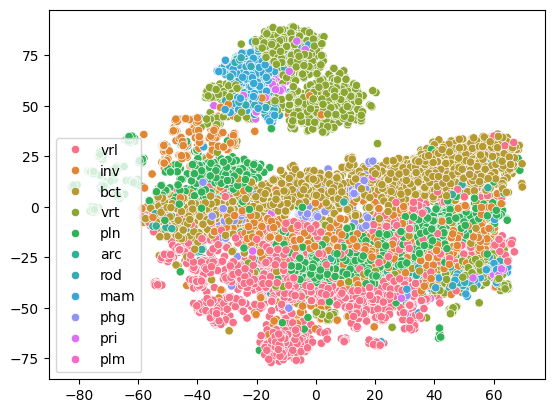

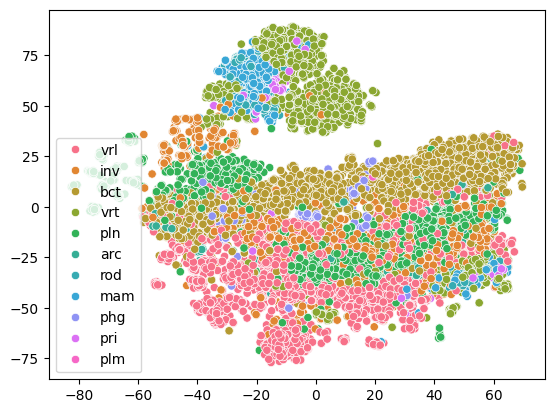

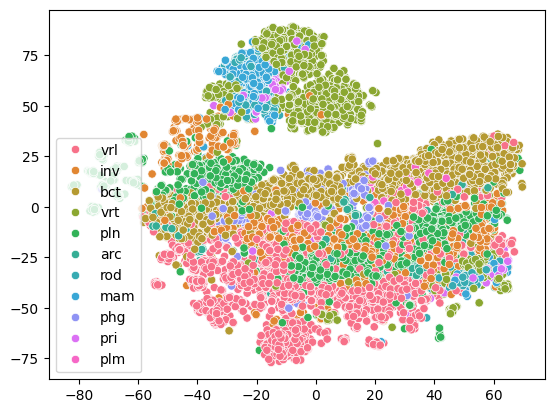

In [56]:
for m in [cvk_svm, cvk_rbf, cvk_sigm]:
    cv_score = m.best_score_
    m = m.best_estimator_
    plt.figure()
    print(m)
    m=m.fit(X_train_noaga, y_train_kingdom)
    sns.scatterplot(x=projections_2d[:,0], y=projections_2d[:,1], hue=m.predict(X_train_noaga), marker='o')
    train_acc = accuracy(m.predict(X_train_noaga), y_train_kingdom)
    print("cv score: {}".format(cv_score))
    print("train score: {}\n".format(train_acc))

<Figure size 640x480 with 0 Axes>

SVC(C=25.00075, class_weight='balanced', degree=2, kernel='poly')


<Axes: >

cv score: 0.9883901094095933
train score: 0.9993283438879293



<Figure size 640x480 with 0 Axes>

SVC(C=50.000499999999995, class_weight='balanced', gamma=100.0)


<Axes: >

cv score: 0.991460574342829
train score: 1.0



<Figure size 640x480 with 0 Axes>

SVC(C=100.0, class_weight='balanced', coef0=-5.0, gamma=75.00025,
    kernel='sigmoid')


<Axes: >

cv score: 0.98215339436704
train score: 0.9868547303780464



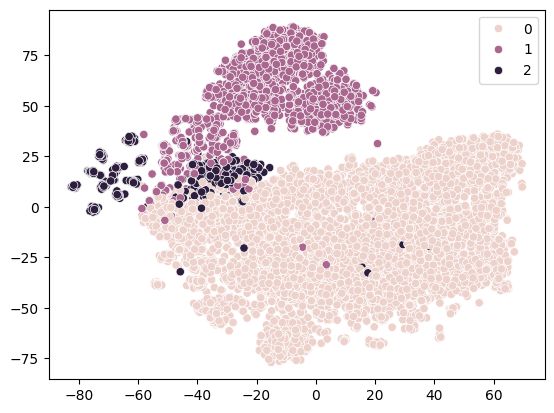

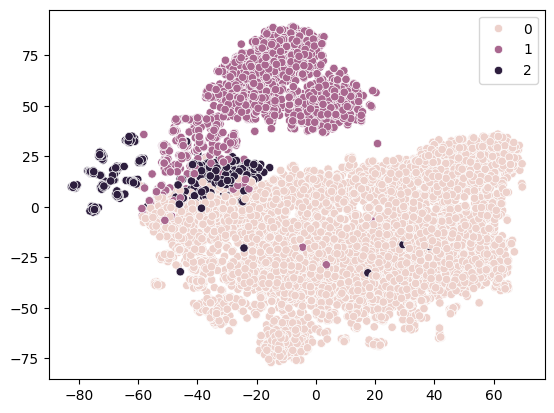

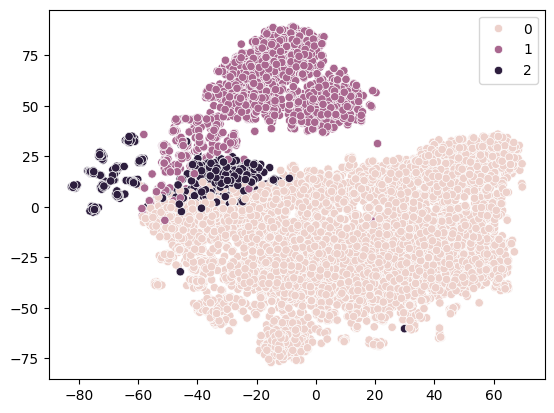

In [57]:
for m in [cvd_svm, cvd_rbf, cvd_sigm]:
    cv_score = m.best_score_
    m = m.best_estimator_
    plt.figure()
    print(m)
    m=m.fit(X_train_noaga, y_train_dnatype)
    sns.scatterplot(x=projections_2d[:,0], y=projections_2d[:,1], hue=m.predict(X_train_noaga), marker='o')
    train_acc = accuracy(m.predict(X_train_noaga), y_train_dnatype)
    print("cv score: {}".format(cv_score))
    print("train score: {}\n".format(train_acc))

These results indicate that for both kingdom and DNA type classifications, the rbf kernel should be chosen. For kingdom classification, the best parameters are SVC(C=25.00075, class_weight='balanced', gamma=100.0), and for DNA type classification, the best parameters are SVC(C=50.000499999999995, class_weight='balanced', gamma=100.0).

### Training Score
Now, I use these parameters to perform cross validation once again, this time to assess the accuracy of the model.

In [58]:
#create the model
model_k = SVC(kernel='rbf', class_weight='balanced', C=25.00075, gamma=100)
#cross validation
scores = cross_val_score(model_k, X_train_noaga, y_train_kingdom, cv=5, scoring=sklearn.metrics.make_scorer(accuracy))
#take the mean of the scores for each iteration
kingdom_val_score=np.mean(scores)
#repeat for DNA type
model_d =  SVC(kernel='rbf', class_weight='balanced', C=50.000499999999995, gamma=100)
scores = cross_val_score(model_d, X_train_noaga, y_train_dnatype, cv=5, scoring=sklearn.metrics.make_scorer(accuracy))
dna_val_score=np.mean(scores)

In [59]:
print("Validation score for Kingdom classification: ", kingdom_val_score)
print("Validation score for DNA type classification: ", dna_val_score)

Validation score for Kingdom classification:  0.9165223214902166
Validation score for DNA type classification:  0.991460574342829


## Final Judgement

After carefully assessing the scores of each model, I decided that the support vector machine utilizing the kernel trick was the best performing model. Now I will use it to predict the classes of the test data.

In [61]:
#create the model
model_k = SVC(kernel='rbf', class_weight='balanced', C=25.00075, gamma=100)
model_d =  SVC(kernel='rbf', class_weight='balanced', C=50.000499999999995, gamma=100)

#fit the model to the training data
model_k=model_k.fit(X_train_noaga, y_train_kingdom)
model_d=model_d.fit(X_train_noaga, y_train_dnatype)

#predict y values for test data
y_pred_k=model_k.predict(X_test)
y_pred_d=model_d.predict(X_test)

#report the accuracy score
print("Accuracy for Kingdom classification: ", accuracy(y_pred_k, y_test_kingdom))
print("Accuracy for DNA type classification: ", accuracy(y_pred_d, y_test_dnatype))

Accuracy for Kingdom classification:  0.9274750575594781
Accuracy for DNA type classification:  0.9934765924788949


The model performs remarkably well on the test data.

# Regression
Now, I will utilize regression in order to predict the missing AGA codon frequencies from the test data.

## Linear Regression

## Logistic Regression